# American Sign Language Identification Model

An Image Classification Project using ResNet9 Architecture in PyTorch

In this project we will be classifying images of the American Sign Language. The dataset used for this project is available for free on kaggle: ttps://www.kaggle.com/datasets/grassknoted/asl-alphabet

# Downloading the Dataset




In [1]:
!pip install jovian opendatasets --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
dataset_url = 'https://www.kaggle.com/datasets/grassknoted/asl-alphabet'

In [3]:
import opendatasets as od
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akshitabakshi
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:10<00:00, 105MB/s]


In [6]:
data_dir = '/content/asl_alphabet_train/asl_alphabet_train'

In [7]:
import os
os.listdir(data_dir)

['C',
 'B',
 'M',
 'R',
 'O',
 'V',
 'H',
 'K',
 'D',
 'L',
 'P',
 'E',
 'T',
 'F',
 'A',
 'nothing',
 'S',
 'Z',
 'G',
 'W',
 'del',
 'X',
 'J',
 'Q',
 'space',
 'U',
 'I',
 'Y',
 'N']

## Importing the dataset into Pytorch

In [8]:
from torchvision.datasets import ImageFolder

In [9]:
dataset = ImageFolder(data_dir)

In [10]:
len(dataset)

87000

In [11]:
dataset.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

As we can see our dataset is split it into two folders. one for training and one for testing purposes

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

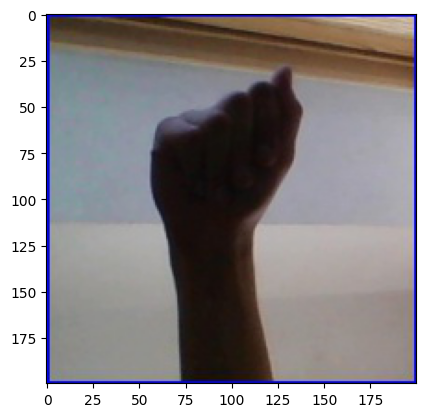

In [13]:
img, label = dataset[0]
plt.imshow(img)

In [14]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(100),tt.RandomCrop(100), tt.ToTensor()]))

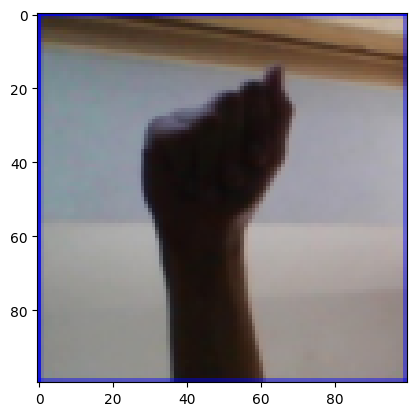

In [15]:
img, label = dataset[0]
plt.imshow(img.permute(1,2,0))

# Splitting the training dataset into training and validation set

In [16]:
val_percent = 0.2
validation_size = int(val_percent * len(dataset))
training_size = int(len(dataset) - validation_size)

print("Training set size:",training_size)
print("Validation set size:",validation_size)

Training set size: 69600
Validation set size: 17400


In [17]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [training_size,validation_size])
print(len(train_ds))
print(len(valid_ds))

69600
17400


In [18]:
batch_size = 100
from torch.utils.data.dataloader import DataLoader

In [19]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, pin_memory=True)

In [20]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(200, 200))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [21]:
show_batch(train_dl)

# Utility Functions and Classes

Functions to move the data to GPU:

In [22]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Moves data to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
torch.cuda.is_available()

True

In [24]:
device = get_default_device()

In [25]:
device

device(type='cuda')

In [26]:
img, label = dataset[0]
img.shape

torch.Size([3, 100, 100])

In [32]:
img.device

device(type='cpu')

In [33]:
imggpu = to_device(img,device)

In [34]:
imggpu.device

device(type='cuda', index=0)

In [35]:
training_dl = DeviceDataLoader(train_dl,device)
validation_dl = DeviceDataLoader(valid_dl,device)

Functions for creating the model and training :

In [36]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    # function to calculate loss for a batch of training data
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    # function to calculate loss and accuracy  for a batch of validation data
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

In [44]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #input 100*3*175*175
        self.conv1 = conv_block(in_channels, 64) # 100 * 64 * 175*175
        self.conv2 = conv_block(64, 128, pool=True)# 100 * 128 * 87.5 * 87.5
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)#100 * 256 * 43.75 * 43.75
        self.conv4 = conv_block(256, 512, pool=True)#100 * 512 * 21.875 * 21.875
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),#100*512*1*1
                                        nn.Flatten(),#100* 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [45]:
model = to_device(ResNet9(3, 29), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [47]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Passing one batch of input tensor to model:

In [48]:
for batch in training_dl:
  images, labels = batch
  print(images.shape)
  #images = to_device(images,device)
  print(images.device)
  preds = model(images)
  print(preds.shape)
  print(preds)
  break

torch.Size([100, 3, 100, 100])
cuda:0
torch.Size([100, 29])
tensor([[ 3.9683,  0.5615,  3.0256,  ...,  0.2269, -2.8435, -2.8677],
        [ 2.0506,  0.9215,  5.3004,  ...,  0.6770, -2.4646, -3.5719],
        [ 2.4385,  2.7149,  6.4196,  ..., -1.5064, -3.6763, -4.4730],
        ...,
        [ 1.4535,  0.1369,  2.2408,  ..., -0.0695, -1.4831, -5.2593],
        [ 2.1249,  0.8325,  0.7316,  ..., -0.8985, -1.7051, -2.6824],
        [ 2.0202, -0.6593,  3.3000,  ...,  3.1355, -3.6154, -3.1944]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


# Training the Model

In [49]:
history = [evaluate(model, validation_dl)]
history

[{'val_loss': 3.3680479526519775, 'val_acc': 0.03465517237782478}]

Initially the validation loss is high and validation accuracy is 0, however since there are 29 categories in this dataset, this doesn't seem very unusual

In [50]:
epochs = 3
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [51]:
%%time
history += fit_one_cycle(epochs, max_lr, model, training_dl, validation_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], train_loss: 0.6302, val_loss: 1.0517, val_acc: 0.8418
Epoch [1], train_loss: 0.0761, val_loss: 0.0063, val_acc: 0.9986
Epoch [2], train_loss: 0.0052, val_loss: 0.0005, val_acc: 0.9998
CPU times: user 12min 50s, sys: 4min 39s, total: 17min 30s
Wall time: 19min 18s


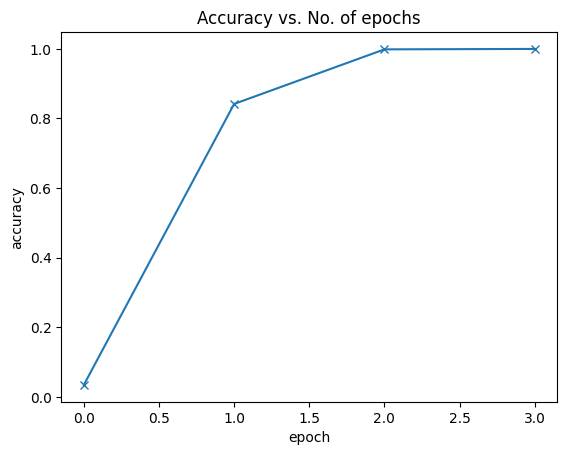

In [52]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
plot_accuracies(history)


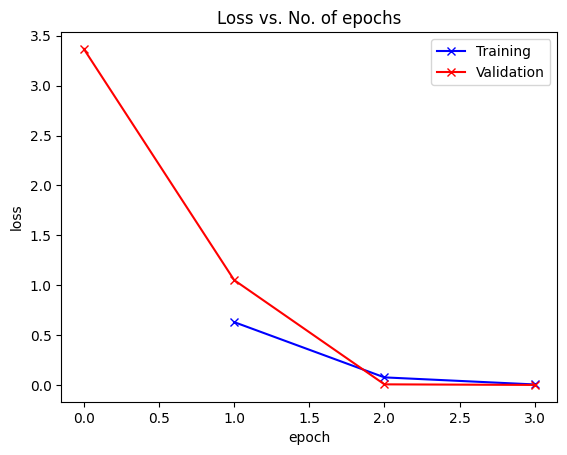

In [53]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
plot_losses(history)

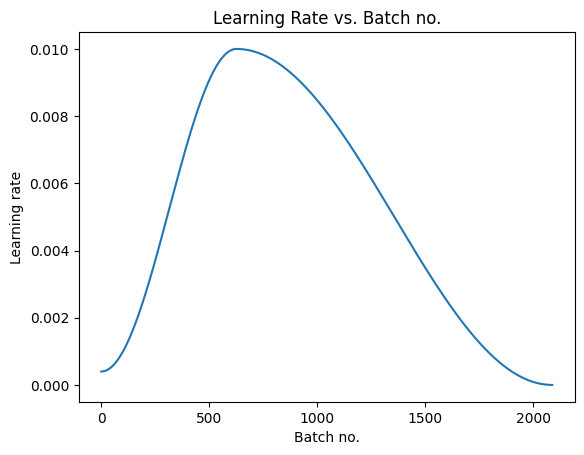

In [54]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

# Testing with images

In [84]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: A , Predicted: A


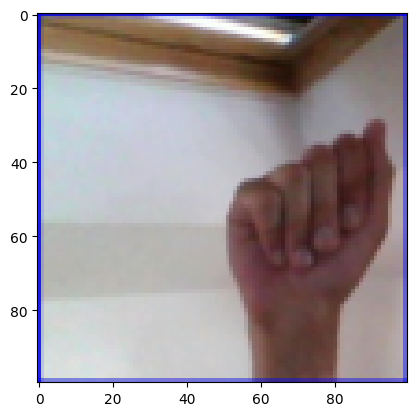

In [86]:
img, label = dataset[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: G , Predicted: G


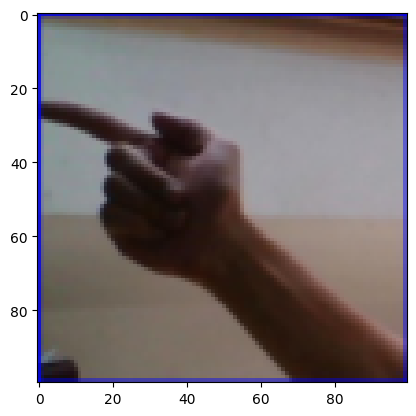

In [88]:
img, label = dataset[20000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: space , Predicted: space


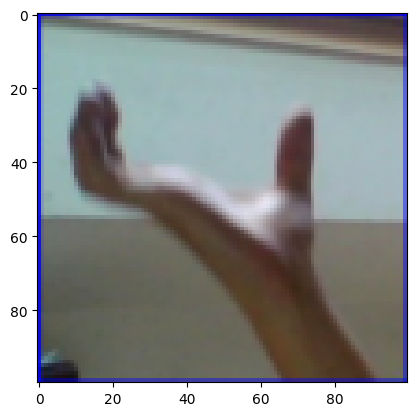

In [89]:
img, label = dataset[86000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: C , Predicted: C


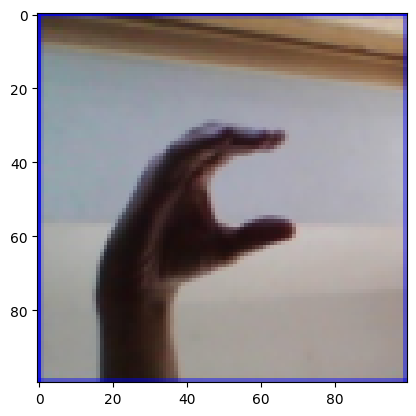

In [90]:
img, label = dataset[8000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))